In [1]:
from datasets import load_dataset, get_observation_pixels

from config import load_config, get_model_name
config = load_config("vae")

train_loader, test_loader, val_loader = load_dataset(config["data_params"])

model_name = get_model_name(config)

from models import VAE
import torch

model = VAE(config["model_params"])

randn = torch.randn(16, 1, 28, 28)

output, _, _,_ = model(randn, _,_)

print(output.shape)

torch.Size([16, 1, 28, 28])


/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [2]:
from trainers import SuperTrainer, VAEModule

model = VAEModule(config['model_params'], model_name=config['model_name'])

from trainers import SuperTrainer
trainer = SuperTrainer(**config['trainer_params'], model_name=model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/pyt ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which wi

/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:630: Checkpoint directory /Home/siv34/edzak2974/projects/MastersThesis/src/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name  | Type | Params
-------------------------------
0 | model | VAE  | 848 K 
-------------------------------
848 K     Trainable params
0         Non-trainable params
848 K     Total params
3.395     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 469/469 [00:06<00:00, 72.98it/s, v_num=i2qv, train_recon_loss=2.85e+3, train_kl_loss=540.0, train_loss=3.39e+3, val_recon_loss=3.69e+3, val_kl_loss=707.0, val_loss=4.4e+3] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 469/469 [00:06<00:00, 72.95it/s, v_num=i2qv, train_recon_loss=2.85e+3, train_kl_loss=540.0, train_loss=3.39e+3, val_recon_loss=3.69e+3, val_kl_loss=707.0, val_loss=4.4e+3]


/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


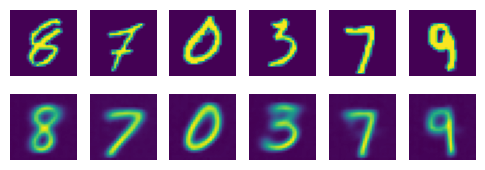

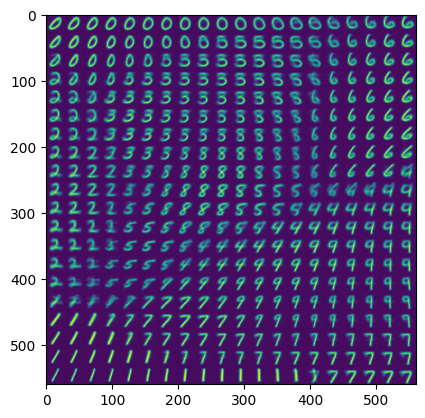

In [3]:
from trainers import VAEModule
model = VAEModule.load_model_checkpoint(model_name)
model.eval()

from plotting import plot_samples_with_reconstruction
from plotting import plot_latent_images
# plot some samples and their reconstructions

plot_samples_with_reconstruction(model, next(iter(test_loader)))
plot_latent_images(model)